# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=5b7022a0236cb7fe6e2dbe37619827b02a8ebbb546c95fd78b8cda33356d1d15
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=840797f0619913ad7684cb2a10a0776fdb41ba5ff487ccb1ef38418fb11c7709
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (3/3), done.


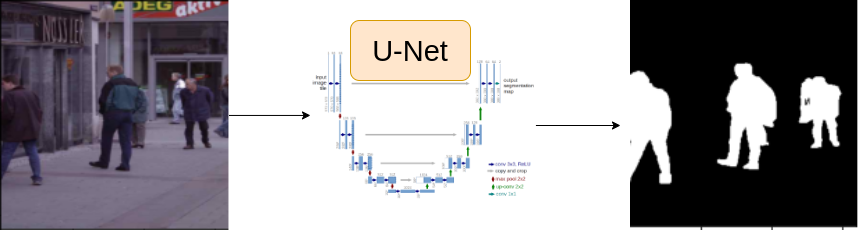

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

In [21]:
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficient-b0'
WEIGHTS = 'imagenet'

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [13]:
row = df.iloc[1]
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

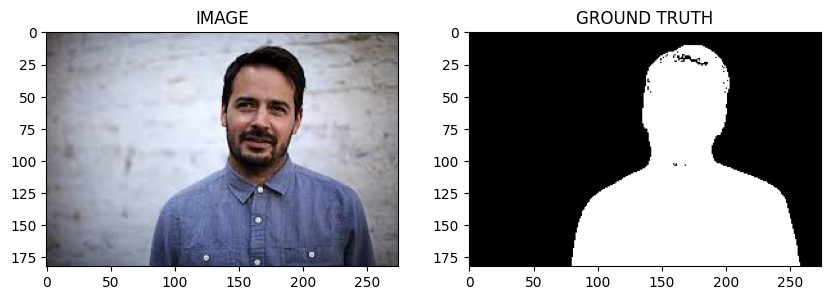

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [16]:
import albumentations as A

In [30]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [31]:
from torch.utils.data import Dataset

In [32]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h, w, channel)
    mask = np.expand_dims(mask, axis = -1)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) --> (c, h, w)
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)
      return image, mask





In [33]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [34]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


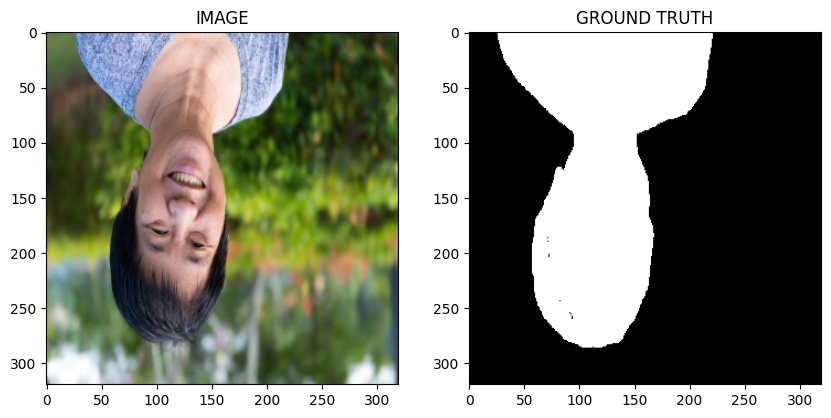

In [38]:
idx = 3
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

# Task 7 : Create Train and Validation Function

# Task 8 : Train Model

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya